In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
import plotly.io as pio
import plotly.graph_objects as go
from itertools import chain
from plots import plot_game_play_id
from distances import calc_dist
from shapely import geometry
from sklearn.preprocessing import StandardScaler
from shapely.ops import unary_union
from shapely.validation import make_valid
from shapely.errors import ShapelyDeprecationWarning

In [2]:
pio.renderers.default = 'jupyterlab'
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
GAMES_PATH='./data/games.csv'
PFF_SCOUTING_DATA_PATH='./data/pffScoutingdata.csv'
PLAYERS_PATH='./data/players.csv'
PLAYS_PATH='./data/plays.csv'
WEEK_PATH='./data/week{}.csv'
WEEK_IDS = [1,2,3,4]
PASS_RESULTS = ['I','C','IN']
SNAP_EVENTS = ['ball_snap', 'autoevent_ballsnap']
NONSNAP_EVENTS = ['autoevent_passforward', 'pass_forward', 'qb_sack', 'autoevent_passinterrupted',
                  'pass_tipped', 'qb_strip_sack', 'autoevent_passinterrupted']
OLINE_POS_lINEDUP= ['C','LT','LG','RT','RG']

In [4]:
def ccworder(A):
    A= A- np.mean(A, 1)[:, None]
    return np.argsort(np.arctan2(A[1, :], A[0, :]))

def gen_snap_df(week_df, snap_events=SNAP_EVENTS):
    snap_df = (week_df
               .query('event.isin(@snap_events)')
               .groupby(['gameId','playId'])
               [['frameId', 'time']].min()
               .reset_index()
               .rename({'frameId': 'snap_frameId',
                        'time': 'snap_time'}, axis=1))
    return snap_df

def gen_nonsnap_df(week_df, nonsnap_events=NONSNAP_EVENTS):
    nonsnap_df = (week_df
               .query('event.isin(@nonsnap_events)')
               .groupby(['gameId','playId'])
               [['frameId','time']].min()
               .reset_index()
               .rename({'frameId': 'nonsnap_frameId',
                        'time': 'nonsnap_time'},axis=1))
    return nonsnap_df

def gen_passer_df(week_df):
    passer_df = (week_df.query('pff_role == "Pass"')
                 [['gameId', 'playId','frameId','time', 'x', 'y', 's','a','dis','o','dir']]
                 .rename({'x': 'qb_x',
                          'y': 'qb_y',
                          's': 'qb_s',
                          'a': 'qb_a',
                          'o': 'qb_o',
                          'dis': 'qb_dis',
                          'dir': 'qb_dir'}, axis=1))
    return passer_df

def gen_line_df(week_df, position, id_cols = ['gameId','nflId', 'playId','frameId'], feats_cols = ['x', 'y', 's','a','dis','o','dir'], oline_pos_lineup=OLINE_POS_lINEDUP, lookback_pd=5, min_speed=0.01, t=0.1):
    
    all_cols = list(chain(*[id_cols, feats_cols]))
    
    rename_cols = {}
    for f in feats_cols:
        renamed_col = f'{position}_{f}'
        rename_cols[f] = renamed_col
    
    if position == 'pb':
        line_df = (week_df
                    .query('pff_role == "Pass Block"'))
                    
        if oline_pos_lineup:
            line_df = (line_df.query('pff_positionLinedUp.isin(@oline_pos_lineup)'))
    else:
        line_df = (week_df
                    .query('pff_role == "Pass Rush"'))
    
    line_df = (line_df[all_cols].rename(rename_cols, axis=1))
    
    line_id_df = line_df[['gameId','playId','nflId']].drop_duplicates().groupby(['gameId', 'playId']).apply(lambda x: x.reset_index(drop=True).reset_index()).reset_index(drop=True).rename({'index': f'{position}_id'}, axis=1)

    line_df = (line_df.merge(line_id_df, how='left', on=['gameId', 'playId', 'nflId']))
    line_df[f'{position}_displacement'] = line_df.apply(lambda x: max(x[f'{position}_s'], min_speed) * t + 0.5*(x[f'{position}_a']) * t**2, axis=1)
    line_df[f'{position}_point'] = line_df.apply(lambda x: geometry.Point(x[f'{position}_x'], x[f'{position}_y']).buffer(x[f'{position}_displacement']), axis=1)
    
    all_movement_paths = []
    for k, df_grp in line_df.groupby(['gameId', 'playId', 'nflId']):
        
        all_paths = []
        for i in range(1, len(df_grp)+1):
            all_paths.append(unary_union(df_grp[f'{position}_point'].values[max(0, i - lookback_pd):i]))
        
        df_grp[f'{position}_movement_path'] = all_paths
        all_movement_paths.append(df_grp)
    line_df_poly = pd.concat(all_movement_paths)
    return line_id_df, line_df_poly

def pivot_line_df(line_df, position):
    line_df = line_df.pivot(index=['gameId', 'playId', 'frameId'], columns=[f'{position}_id'], values=[f'{position}_point', f'{position}_movement_path', f'{position}_x', f'{position}_y', f'{position}_o', f'{position}_dir', f'{position}_s', f'{position}_a', f'{position}_dis'])
    line_df.columns = ['{}_{}'.format(c[0], c[1]) for c in line_df.columns]
    line_df.reset_index(inplace=True)
    return line_df

def gen_pocket_polygon(row):
    
    # row = pocket_area_df.iloc[0]
    
    all_coords = []
    for c in row.index.values:
        
        if 'pb_x' in c:
            if not(pd.isnull(row[c])):
                all_coords.append((row[c], row[c.replace('_x', '_y')]))
    
    all_coords2 = np.array(all_coords)[np.argsort(np.array(all_coords)[:,1])]
    oline_coords2 = np.vstack([all_coords2,[row['qb_x'], row['qb_y']]])
    
    all_coords.append((row['qb_x'], row['qb_y']))
    
    A = np.array(all_coords).T
    sorted_order = ccworder(A)
    oline_coords = A.T[sorted_order]
    
    geom1 = geometry.Polygon(oline_coords)
    geom2 = geometry.Polygon(oline_coords2)
    
    if geom1.area > geom2.area:
        return geom1
    else:
        return geom2
    
def gen_pocket_area_df(passer_df, pass_blockers_df, snap_df, nonsnap_df):
    
    pass_blockers_df = pivot_line_df(pass_blockers_df, position='pb')
    
    pocket_area_df = (passer_df
                          .merge(pass_blockers_df, how='left', on=['gameId', 'playId', 'frameId'])
                          .merge(snap_df, how='left', on=['gameId', 'playId'])
                          .merge(nonsnap_df, how='left', on=['gameId', 'playId'])
                          .query('(frameId >= snap_frameId) & (frameId <= nonsnap_frameId)')
                          .assign(
                              time_since_snap = lambda x: (pd.to_datetime(x['time']) - pd.to_datetime(x['snap_time'])).dt.total_seconds()
                              ))
    
    pocket_area_df['pocket_polygon'] = pocket_area_df.apply(lambda x: gen_pocket_polygon(x), axis=1)
    pocket_area_df['pocket_area'] = pocket_area_df['pocket_polygon'].apply(lambda x: x.area)
    return pocket_area_df

def gen_pocket_adj_risk_poly(row):
    pocket_poly = row['pocket_polygon']
    pocket_poly = make_valid(pocket_poly)
    
    pb_paths = [p for p in row.index.values if 'pb_movement_path' in p]
    pr_paths = [p for p in row.index.values if 'pr_movement_path' in p]
    
    pb_paths_poly = [p for p in row[pb_paths].values if not(pd.isnull(p))]
    pr_paths_poly = [p for p in row[pr_paths].values if not(pd.isnull(p))]
    
    pr_combined = unary_union(pr_paths_poly)
    pb_combined = unary_union(pb_paths_poly)
    
    attack_polys = (pr_combined.symmetric_difference(pb_combined)).difference(pb_combined)
    attack_polys = make_valid(attack_polys)
    
    attack_in_pocket_poly = pocket_poly.intersection(attack_polys)
    
    return attack_in_pocket_poly

def nthHarmonic(N) :
 
    # H1 = 1
    harmonic = 1.00
 
    # loop to apply the formula
    # Hn = H1 + H2 + H3 ... +
    # Hn-1 + Hn-1 + 1/n
    for i in range(2, N + 1) :
        harmonic += 1 / i
 
    return harmonic

# 1. Load Data

In [5]:
games_df = pd.read_csv(GAMES_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
pff_scouting_df = pd.read_csv(PFF_SCOUTING_DATA_PATH)

games_df = games_df.query('week.isin(@WEEK_IDS)')
plays_df = plays_df.merge(games_df, how='inner', on=['gameId'])
pff_scouting_df = pff_scouting_df.merge(games_df['gameId'], how='inner', on='gameId', validate='m:1')

In [6]:
#Filter for pass plays only
plays_df = (plays_df
            .query('(pff_playAction == 0) & (passResult.isin(@PASS_RESULTS))')
            .query('foulName1.isna()')
            .query('dropBackType == "TRADITIONAL"'))

#Load the weekly data
week_df = []
for week_id in WEEK_IDS:
    week_df.append(pd.read_csv(WEEK_PATH.format(week_id)))
week_df = pd.concat(week_df)

week_df = (week_df
           .merge(players_df, how='left', on='nflId', validate='m:1')
           .merge(pff_scouting_df, how='left', on=['nflId', 'gameId', 'playId'], validate='m:1')
           .merge(plays_df, how='inner', on=['gameId', 'playId'], validate='m:1')
           )

#Generate the snap event dataframe
snap_df = gen_snap_df(week_df)
nonsnap_df = gen_nonsnap_df(week_df)

#Get the QB dataframe
passer_df = gen_passer_df(week_df)

#Get the pass blockers dataframe
pass_blockers_id_df, pass_blockers_poly_df = gen_line_df(week_df, position='pb')
all_pass_blockers_id_df, all_pass_blockers_poly_df = gen_line_df(week_df, position='pb', oline_pos_lineup=None)
pass_rushers_id_df, pass_rushers_poly_df = gen_line_df(week_df, position='pr')

# 2. Pocket Area Generation

In [23]:
pocket_area_df = gen_pocket_area_df(passer_df, pass_blockers_poly_df, snap_df, nonsnap_df)
pocket_area_df = pocket_area_df.drop([c for c in pocket_area_df.columns if 'pb_' in c], axis=1)
pocket_area_df = pocket_area_df.merge(pivot_line_df(all_pass_blockers_poly_df, 'pb'), how='left', on=['gameId', 'playId', 'frameId'])

pb_movement_cols = [c for c in pocket_area_df.columns if 'pb_movement_path' in c]
all_cols = list(chain(*[['gameId', 'playId', 'frameId', 'time', 'time_since_snap','snap_frameId','nonsnap_frameId', 'pocket_polygon', 'pocket_area'], pb_movement_cols]))

pocket_area_df = pocket_area_df[all_cols]
pocket_area_df = pocket_area_df.merge(pivot_line_df(pass_rushers_poly_df, 'pr')[['gameId', 'playId', 'frameId', 'pr_movement_path_0', 'pr_movement_path_1', 'pr_movement_path_2',
                                                       'pr_movement_path_3', 'pr_movement_path_4', 'pr_movement_path_5', 'pr_movement_path_6']], how='left', on=['gameId', 'playId', 'frameId'])

week_df_append_polygon = pocket_area_df[['gameId', 'playId', 'frameId', 'pocket_polygon']]
week_df_append_polygon['team'] = 'pocket_polygon'

C:\Users\ben\AppData\Local\Temp\ipykernel_8136\2991543820.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
pocket_area_df.head()

,gameId,playId,frameId,time,time_since_snap,snap_frameId,nonsnap_frameId,pocket_polygon,pocket_area,pb_movement_path_0,pb_movement_path_1,pb_movement_path_2,pb_movement_path_3,pb_movement_path_4,pb_movement_path_5,pb_movement_path_6,pb_movement_path_7,pb_movement_path_8,pr_movement_path_0,pr_movement_path_1,pr_movement_path_2,pr_movement_path_3,pr_movement_path_4,pr_movement_path_5,pr_movement_path_6
0,2021090900,97,6,2021-09-10T00:26:31.600,0.0,6.0,38.0,"POLYGON ((41.11 21.31, 41.41 22.63, 42.1 24.02...",12.63610,(POLYGON ((42.15201060982483 23.96960006483986...,(POLYGON ((41.540980785280404 26.8798049096779...,(POLYGON ((41.93171637424071 25.64965859193647...,(POLYGON ((41.420980785280406 22.6198049096779...,(POLYGON ((41.148495822255825 21.3023427048608...,NaN,NaN,NaN,NaN,"POLYGON ((43.67948462725645 18.73816777196972,...",(POLYGON ((43.948254635795834 32.6204015561568...,(POLYGON ((43.4463260650586 25.138741667422998...,(POLYGON ((43.710980785280405 21.8798049096779...,(POLYGON ((43.69102982454442 26.65979515516188...,NaN,NaN
1,2021090900,97,7,2021-09-10T00:26:31.700,0.1,6.0,38.0,"POLYGON ((41.07 21.27, 41.4 22.64, 42.03 24.06...",12.95585,POLYGON ((42.15201060982483 23.969600064839867...,(POLYGON ((41.52123400132073 26.88577629452835...,(POLYGON ((41.938782038119726 25.6462640203333...,(POLYGON ((41.420980785280406 22.6298049096779...,(POLYGON ((41.134192396602394 21.2572313384240...,NaN,NaN,NaN,NaN,POLYGON ((43.65414335733838 18.787241092940146...,(POLYGON ((43.93079525699698 32.57824923752896...,(POLYGON ((43.4463260650586 25.138741667422998...,POLYGON ((43.710980785280405 21.88980490967798...,(POLYGON ((43.69102982454442 26.65979515516188...,NaN,NaN
2,2021090900,97,8,2021-09-10T00:26:31.800,0.2,6.0,38.0,"POLYGON ((40.99 21.21, 41.37 22.66, 41.95 24.1...",13.39680,POLYGON ((42.15707304564827 23.974195301449903...,POLYGON ((41.52123400132073 26.885776294528352...,(POLYGON ((41.933607113934535 25.6319373419923...,(POLYGON ((41.420980785280406 22.6298049096779...,"POLYGON ((41.08489097587901 21.19112501134494,...",NaN,NaN,NaN,NaN,POLYGON ((43.587625145083805 18.81654852229698...,(POLYGON ((43.85985693610087 32.48544099491002...,(POLYGON ((43.4463260650586 25.138741667422998...,POLYGON ((43.72928446034026 21.920196711318688...,(POLYGON ((43.70127502086453 26.65974638258138...,NaN,NaN
3,2021090900,97,9,2021-09-10T00:26:31.900,0.3,6.0,38.0,"POLYGON ((40.87 21.14, 41.32 22.68, 41.86 24.1...",13.94870,POLYGON ((42.162656139977315 23.98549341356142...,POLYGON ((41.51869999903214 26.898323844227335...,POLYGON ((41.89384618138736 25.596153818612642...,(POLYGON ((41.420980785280406 22.6298049096779...,POLYGON ((41.000622355827446 21.10037614155476...,NaN,NaN,NaN,NaN,POLYGON ((43.498270675236284 18.85244187101855...,(POLYGON ((43.68157059867451 32.33199661831228...,POLYGON ((43.437363909323246 25.15455698001575...,POLYGON ((43.72928446034026 21.920196711318688...,(POLYGON ((43.70127502086453 26.65974638258138...,NaN,NaN
4,2021090900,97,10,2021-09-10T00:26:32.000,0.4,6.0,38.0,"POLYGON ((40.75 21.05, 41.25 22.69, 41.74 24.2...",14.44050,POLYGON ((42.159729823576555 24.00811899938921...,"POLYGON ((41.477588135400126 26.9005885129594,...",POLYGON ((41.89384618138736 25.596153818612642...,POLYGON ((41.420596490888464 22.63590310323766...,"POLYGON ((40.89209267210023 20.99114328810225,...",NaN,NaN,NaN,NaN,POLYGON ((43.398568920680525 18.87039342263738...,"POLYGON ((43.44861611805921 32.17264506632393,...",POLYGON ((43.41679147759546 25.166714349070702...,POLYGON ((43.72928446034026 21.920196711318688...,(POLYGON ((43.68539832890233 26.66693708194434...,NaN,NaN


In [26]:
week_df_appended = pd.concat([week_df, week_df_append_polygon], axis=0)

In [30]:
all_gameplays_df = week_df_appended[['gameId', 'playId']].drop_duplicates().reset_index(drop=True)

E:\kaggle\nfl-big-data-bowl-2023\plots.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



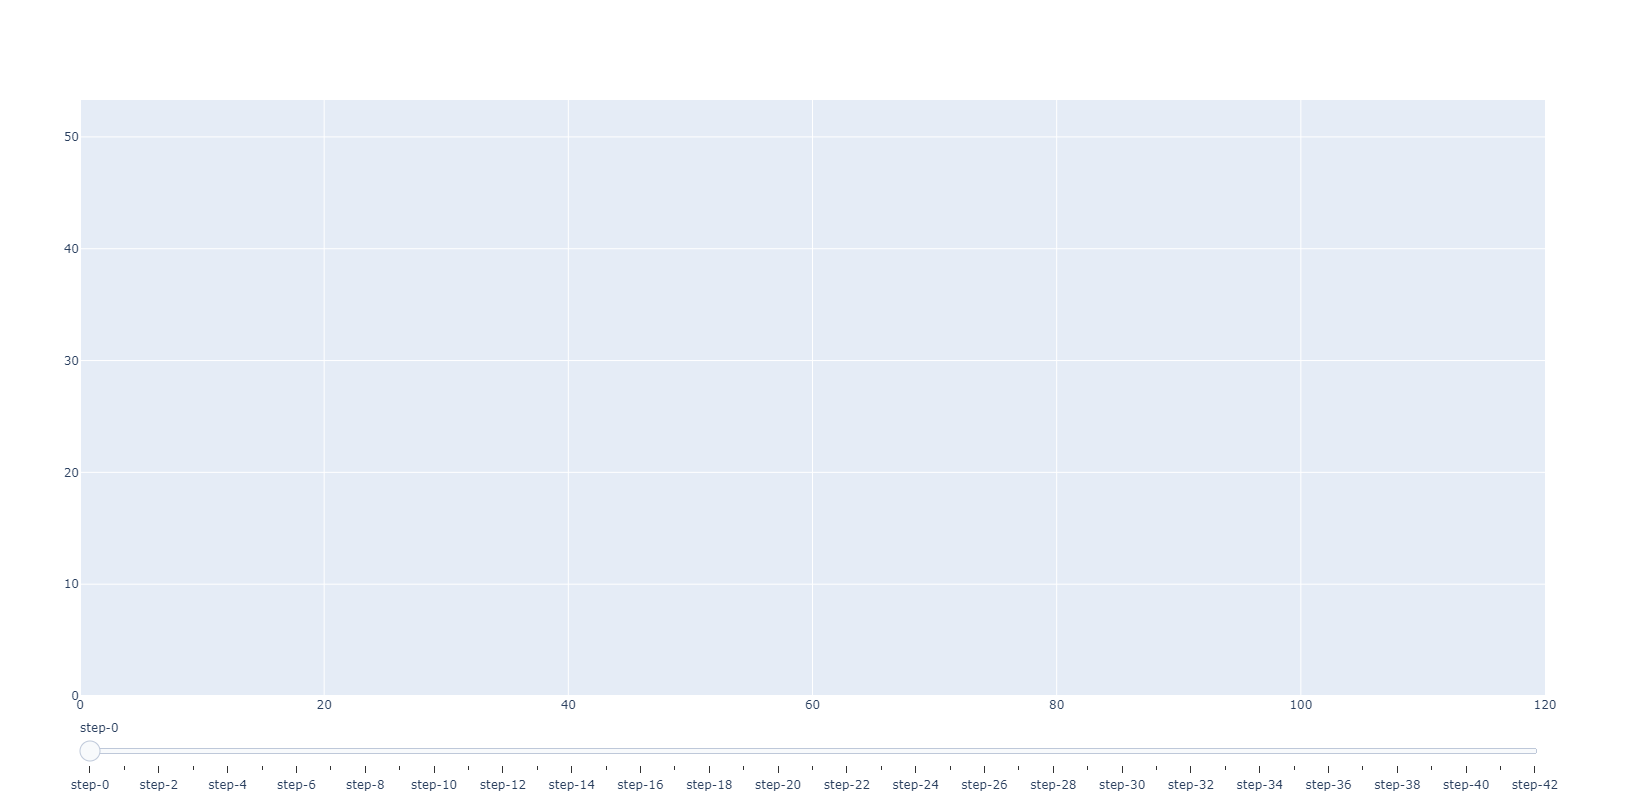

In [35]:
idx = 0
gameId = all_gameplays_df['gameId'].values[idx]
playId = all_gameplays_df['playId'].values[idx]
plot_game_play_id(week_df_appended, gameId, playId, size=(1200, 800))

In [57]:
import glob
from PIL import Image
import os
import re

In [62]:
def make_gif(frame_folder, fname):
    all_fnames = glob.glob(f"{frame_folder}/*.png")
    l = sorted(all_fnames, key=get_key)
    frames = [Image.open(image) for image in l]
    frame_one = frames[0]
    frame_one.save(fname, format="GIF", append_images=frames, save_all=True, duration=200, loop=0)
    
def get_key(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    int_part = filename[filename.find("(")+1:filename.find(")")]
    return int(int_part)

In [63]:
make_gif('./images/pocket_polygon', 'pocket_polygon.gif')

In [44]:
frame_folder = './images/pocket_polygon'
all_fnames = glob.glob(f"{frame_folder}/*.png")

In [58]:
filename = os.path.splitext(os.path.basename(all_fnames[0]))[0]


'-1'